# Learning spatial representations with Slow Feature Analysis

#### 0. the general framework

In [1]:
# load basics
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from geometry import getIntersectPoint
import mdp
from scipy import linalg as LA
from copy import deepcopy as copy
import time as timer
import matplotlib as mpl


def rotate(vec,angle):
    return np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]])@vec
def sign(x):
    a = np.sign(x)
    a[a==0] = 1
    return a
class room_with_bat():
    '''
    Defining square room for the bat to fly in.
    Main feature is that it let's the bat bounce off the wall.
    '''
    
    def __init__(self,size, sensors = None,num_sens = 4):
        
        #Initialize bat position somewhere in the room
        self.bat_posi = np.array([np.random.uniform(-size[i]/2+.01,size[i]/2-.1) for i in range(2)])
        #Start out with zero velocity
        self.bat_velo = np.zeros(2)
        
        #Helper variables
        self.Xmax = size[0]
        self.Ymax = size[1]
        self.corners = [(-self.Xmax/2,-self.Ymax/2),(-self.Xmax/2,self.Ymax/2),\
                        (self.Xmax/2,-self.Ymax/2),(self.Xmax/2,self.Ymax/2)]
        
        #Wall locations
        self.walls   = [[self.corners[i],self.corners[j]] for i,j in [[0,1],[0,2],[1,3],[2,3]]]
        
        #Initializing sensors of bat
        
        self.num_sens = num_sens
        #These are the sensors measured with respect to having the bat look upwards
        self.fix_sensors = np.array([np.max((self.Xmax,self.Ymax))**2*np.array([np.cos(angle),np.sin(angle)]) \
                                 for angle in np.linspace(0,2*np.pi,num_sens+1)[:-1]]).reshape(-1,2)

        #These will be the relative sensor directions, given that the bat looks in different directions
        self.sensors = copy(self.fix_sensors)
    def random_flight(self,time,alpha=2,beta=6,head_fixed = False, verbose=False):
        '''
        Flying through the room and sensing distance to walls
        
        '''
        #Keep track of location over time
        self.track = np.zeros((len(time),2))
        #Keeping track of measured distance to wall per sensor over time
        self.dists = np.zeros((len(time),self.num_sens))
        #starting position of bat
        self.track[0] = self.bat_posi
        #time resolution
        dt = time[1]-time[0]
        
        for t,_ in enumerate(time[:-1]):
            #Measure distance for this time point
            self.dists[t] = self.calc_dists(self.bat_posi)
            #update velocity and position via ODEs where there is noise in the velocity 
            #viscous environment, equilibrium velo is zero
            self.bat_posi += dt * self.bat_velo
            self.bat_velo += dt*alpha * (-self.bat_velo) + beta*np.sqrt(dt) * np.random.randn(2)
            
            #stay inside smaller bounds to avoid geometry.py errors
            xmax= self.Xmax-.01
            ymax= self.Ymax-.01
            
            is_outsideX =  np.abs(self.bat_posi[0])>xmax/2
            is_outsideY =  np.abs(self.bat_posi[1])>ymax/2
            
            
            if is_outsideX:
                #if the bat got outside due to the position update, set it's position and velocity
                #as if it had been reflected off the wall. 
                self.bat_posi[0] = - (self.bat_posi[0]-np.sign(self.bat_posi[0])*xmax)
                self.bat_velo[0] *= - .5
            if is_outsideY:
                #if the bat got outside due to the position update, set it's position and velocity
                #as if it had been reflected off the wall. 
                self.bat_posi[1] = - (self.bat_posi[1]-np.sign(self.bat_posi[1])*ymax)
                self.bat_velo[1] *= - .5
            
            
            #saving position
            self.track[t+1] = self.bat_posi
            
            if verbose and int(t/len(time)*100)==t/len(time)*100:
                print('\r{0:.2f}'.format((t+1)/len(time)*100),end='')
              
            #calculating head direction
            if not head_fixed:
                direction = self.track[t+1] - self.track[t]
                if LA.norm(direction)<10**-5:
                    direction = np.array([1,0])
            
                #calculate angle with respect to looking right
                angle     = np.arccos(np.array([1,0])@direction / LA.norm(direction))
            
                self.sensors = np.array([rotate(sens,angle) for sens in self.fix_sensors])
            
        #saving distance of last position
        self.dists[-1] = self.calc_dists(self.bat_posi)
            
    def set_sensors(self,sensors):
        '''
        allow to set arbitrary sensors
        
        '''
        self.num_sens = len(sensors)
        self.fix_sensors = np.array(sensors)
        self.sensors = np.array(sensors)
        
    def calc_dists(self,pos):
        
        '''
        measuring distances for each sensor
        '''
        dists = []

        for sensor in self.sensors:
            #using geometry.py, all intersections with walls are measured if both 
            #sensor and walls were infinite lines (there were issues with finite lines of geometry..)
            intersect  = np.array([getIntersectPoint(*wall,pos,pos+sensor) for wall in self.walls])

            #resolve numerical issues in order to calculate intersections properly
            self.sensors[np.abs(self.sensors)<10**(-5)] = 0
            #if direction of intersection is the same as direction of sensor and not antiparallel
            #as well as no intersection due to being parallel, save intersections
            #NOTE: there will still most of the times be two intersections,
            #      since the infinite lines will intersect with two walls if not parallel to one of them
            intersect = np.array([x for x in intersect if x is not None and np.all(sign(x-pos)==sign(sensor))])
            #Since there might still be two intersections left, choose the intersection that will be hit first
            #(Closer wall in right direction, final distance received by sensor!)
            distis = np.array([np.linalg.norm(pos-sect) for sect in intersect])


            #save distance of sensor
            dists.append(np.min(distis))


        #Return all distances measured by sensors
        return np.array(dists)
            
            
            
    def extract_slow_features(self,expansion=1,whitening=False,ICA=False,J=100):
        if whitening:
            self.flow = mdp.nodes.PolynomialExpansionNode(expansion,input_dim=self.num_sens) \
                    +mdp.nodes.WhiteningNode(reduce=True)\
                    +mdp.nodes.SFANode()
        elif ICA:
            self.flow = mdp.nodes.PolynomialExpansionNode(expansion,input_dim=self.num_sens) \
                    +mdp.nodes.WhiteningNode(x^reduce=True)\
                    +mdp.nodes.SFANode(output_dim=J)\
                    +mdp.nodes.CuBICANode()
        else:
            self.flow = mdp.nodes.PolynomialExpansionNode(expansion) \
                    +mdp.nodes.SFANode(output_dim=self.num_sens)
        
        self.flow.train(self.dists)
                
    def sfs_per_area(self):
        
        xmax= self.Xmax-.1
        ymax= self.Ymax-.1
        n=20
        xs = np.linspace(-xmax/2,xmax/2,n)
        ys = np.linspace(-ymax/2,ymax/2,n)
        #For displaying the assignment areas in Voronoi tesselation plot 
        
        gridx1, gridx2 = np.meshgrid(xs,ys)

        grid = np.zeros((n*n,2))
        grid[:,0]=gridx1.flatten()
        grid[:,1]=gridx2.flatten()

        real_sigs = np.zeros((grid.shape[0],self.num_sens))
        sfa_sigs = []
        
        for i in range(grid.shape[0]):
        
                real_sigs[i] = self.calc_dists(grid[i])
                sfa_sigs.append(self.flow(real_sigs[i].reshape(1,-1)))

        sfa_sigs=np.array(sfa_sigs)
        return real_sigs.reshape(n,n,-1), sfa_sigs.reshape(n,n,-1)
        
                

/opt/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [117]:
def plot_sfa(sfa,rows=5,cols=5,titles=[''],steps=1):
    fig = plt.figure(figsize=(8,12))

    axes = np.array([    fig.add_axes([0.1 + .8/cols *(i%cols),  0.95-(int(1+i/cols)*.8/rows), .8/cols - 0.1, .8/rows - 0.05])\
                                             for i in range(len(titles))    ])
    
    minsig = np.min(sfa)
    maxsig = np.max(sfa)
    norm = mpl.colors.Normalize(vmin=minsig, vmax=maxsig)
    for sf,ax,title in zip(sfa.T[::steps],axes.flatten(),titles):
        ax.imshow(sf,aspect=size[1]/size[0], extent=[-size[0]/2,size[0]/2,-size[1]/2,size[1]/2],interpolation='gaussian')
        ax.set_xlabel('Position x')
        ax.set_ylabel('Position y')
        ax.set_title(title)
    cbar = fig.add_axes([.85,.25,.025,.5])
    
    cbar1 = mpl.colorbar.ColorbarBase(cbar,
                                norm=norm,
                                orientation='vertical')
    cbar1.set_label('Signal strength');
    #plt.subplots_adjust()
    #fig.tight_layout()
    return fig

#### 1: implement random walk in rectangular room

In [85]:
size = (4,2)
test_bat = room_with_bat(size = size,num_sens=2)

strt = timer.time()
time = (np.arange(0,1500,.025))
test_bat.random_flight(time,head_fixed=True)
print('Total time was {0:.2f} seconds'.format(timer.time()-strt))

Total time was 10.83 seconds


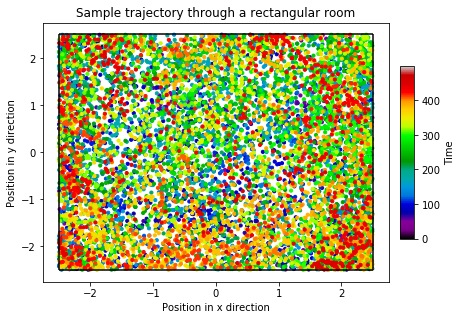

In [193]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0.2, 0.2, .6, .6])
ax1 = fig.add_axes([.82, 0.3, .025, .4])

color = plt.cm.nipy_spectral(np.linspace(0.1,0.9,len(time)))

ax.scatter(*test_bat.track.T, color = color,s=10)
ax.hlines(size[1]/2,-size[0]/2,size[0]/2)
ax.hlines(-size[1]/2,-size[0]/2,size[0]/2)
ax.vlines(size[0]/2,-size[1]/2,size[1]/2)
ax.vlines(-size[0]/2,-size[1]/2,size[1]/2)

cmap = plt.cm.nipy_spectral
norm = mpl.colors.Normalize(vmin=time[0], vmax=time[-1])

#[plt.arrow(*test_bat.bat_posi, *(1*sens/np.linalg.norm(sens))) for sens in test_bat.sensors];
#[plt.arrow(*test_bat.bat_posi, *(1*sens/np.linalg.norm(sens)),color='red') for sens in test_bat.fix_sensors];
#ax.axes().set_aspect('equal', 'datalim')
#cbar = plt.colorbar(color)
#cbar.ax.set_ylabel('# of contacts', rotation=270)

ax.set_title('Sample trajectory through a rectangular room')
ax.set_xlabel('Position in x direction')
ax.set_ylabel('Position in y direction');


# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Time');
#fig.tight_layout()
fig.savefig('Sample_trajectory.png')

In [20]:
xmax= 10
ymax= 10
n=10
xs = np.linspace(-xmax/2,xmax/2,n)
ys = np.linspace(-ymax/2,ymax/2,n)
#For displaying the assignment areas in Voronoi tesselation plot 

gridx1, gridx2 = np.meshgrid(xs,ys)

grid = np.zeros((n*n,2))
grid[:,0]=gridx1.flatten()
grid[:,1]=gridx2.flatten()


#### 3. starting with 2 orthogonal sensors

In [91]:
size = (4,2)
test_bat = room_with_bat(size = size)
# set 2 orthogonal sensors
test_bat.set_sensors([[1,0],[0,1]])

In [192]:
time = (np.arange(0,500,.05))
test_bat.random_flight(time,head_fixed=True,verbose=True)

99.01

In [152]:
test_bat.extract_slow_features(expansion=1,whitening=True)
sig, sfa =test_bat.sfs_per_area()

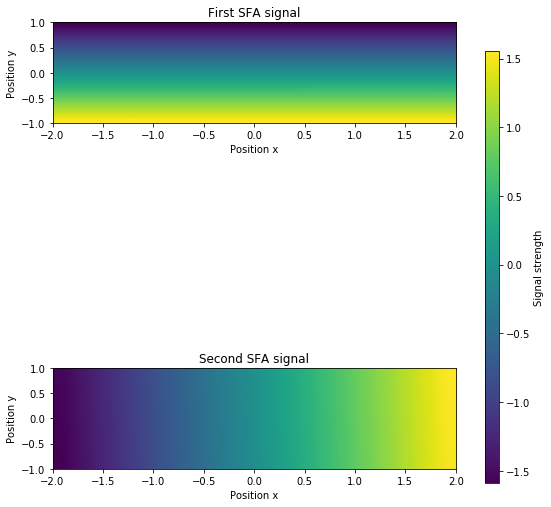

In [153]:
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in ['First','Second']],rows=2,cols=1)
fig.savefig('2orthogonal_sens.png')

In [189]:
# what changes when you make the room quadratic?
size = (5,5)
test_bat = room_with_bat(size = size)
# set 2 orthogonal sensors
test_bat.set_sensors([[1,0],[0,1]])

In [190]:
test_bat.random_flight(time,head_fixed=True,verbose=True,alpha=1)

99.00

In [185]:
test_bat.extract_slow_features(expansion=1)
sig, sfa =test_bat.sfs_per_area()

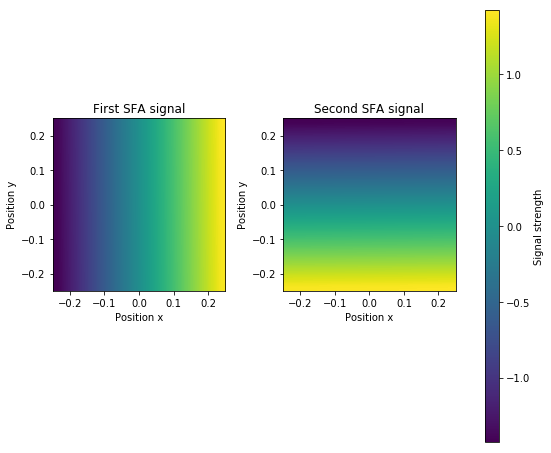

In [188]:
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in ['First','Second']],rows=1,cols=2)
#fig.savefig('small_room.png')

#### 4. random direction sensors

In [145]:
size = (4,2)
test_bat = room_with_bat(size = size)


99.00

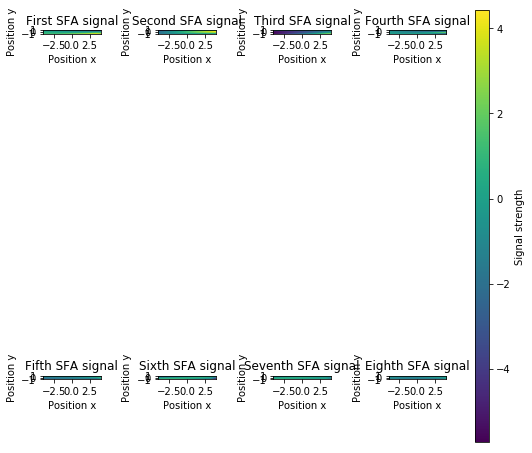

In [144]:
n=8
sensors=np.array([[np.cos(alpha),np.sin(alpha)] for alpha in np.random.uniform(0,2*np.pi,size=n)])
test_bat.set_sensors(sensors)
test_bat.random_flight(time,head_fixed=True,verbose=True)
test_bat.extract_slow_features(expansion=1,whitening=True)
sig, sfa =test_bat.sfs_per_area()
counts = ['First','Second','Third','Fourth','Fifth','Sixth','Seventh','Eighth']
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in counts],rows=4,cols=2)
fig.savefig('8random_sens.png')

#### 5. vary degree of polynomial expansion

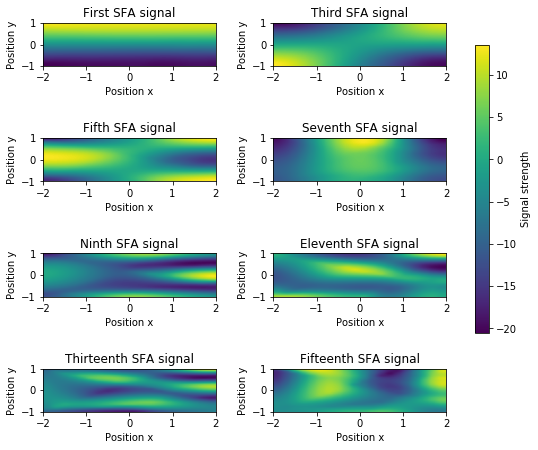

In [101]:
test_bat.extract_slow_features(expansion=3,whitening=True)
sig, sfa =test_bat.sfs_per_area()
counts = ['First','Third','Fifth','Seventh','Ninth','Eleventh','Thirteenth','Fifteenth']
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in counts],rows=4,cols=2,steps=2)
fig.savefig('8random_sens_exp3.png')

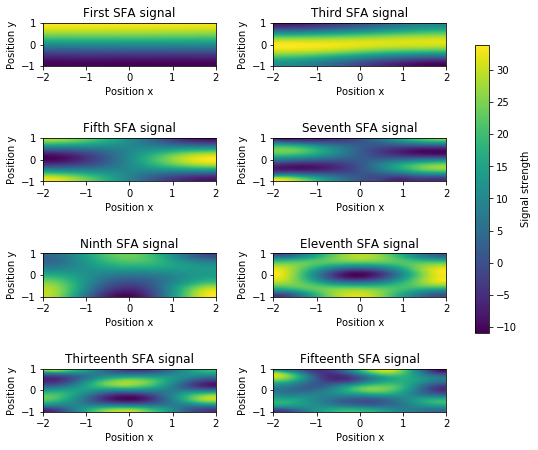

In [102]:
test_bat.extract_slow_features(expansion=5,whitening=True)
sig, sfa =test_bat.sfs_per_area()
counts = ['First','Third','Fifth','Seventh','Ninth','Eleventh','Thirteenth','Fifteenth']
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in counts],rows=4,cols=2,steps=2)
fig.savefig('8random_sens_exp5.png')

In [103]:
test_bat.extract_slow_features(expansion=6,whitening=True)
sig, sfa =test_bat.sfs_per_area()

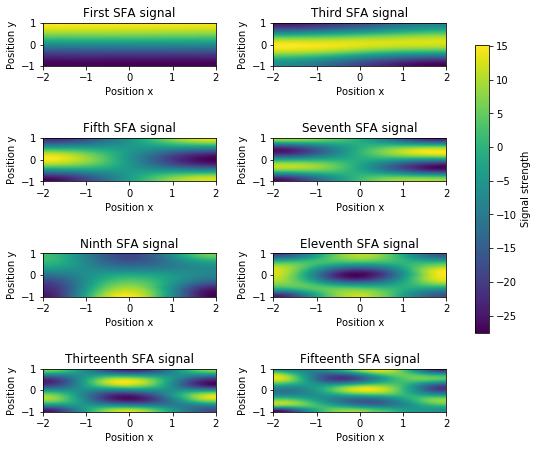

In [104]:

counts = ['First','Third','Fifth','Seventh','Ninth','Eleventh','Thirteenth','Fifteenth']
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in counts],rows=4,cols=2,steps=2)
fig.savefig('8random_sens_exp6.png')

In [ ]:
size = (8,2)
test_bat = room_with_bat(size = size)

# vary shape


test_bat = room_with_bat(size = size)
test_bat.set_sensors(sensors)
test_bat.random_flight(time,head_fixed=True,verbose=True)

In [106]:
test_bat.extract_slow_features(expansion=5,whitening=True)
sig, sfa =test_bat.sfs_per_area()

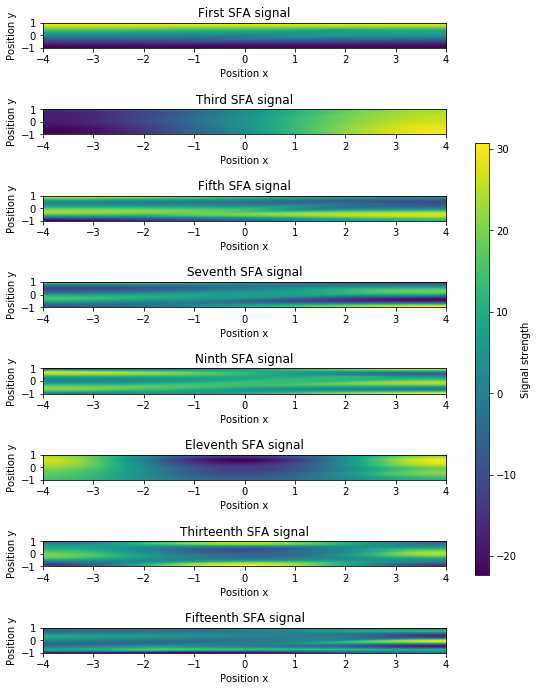

In [118]:
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in counts],rows=8,cols=1,steps=2)
fig.savefig('8random_sens_exp5_elon.png')

#### 6. Add ICA

In [119]:
size = (4,2)
test_bat = room_with_bat(size = size)
test_bat.set_sensors(sensors)
test_bat.random_flight(time,head_fixed=True,verbose=True)

99.00

8


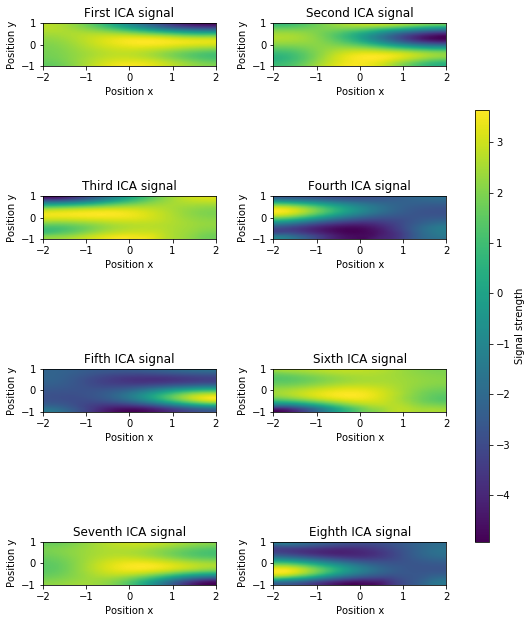

28


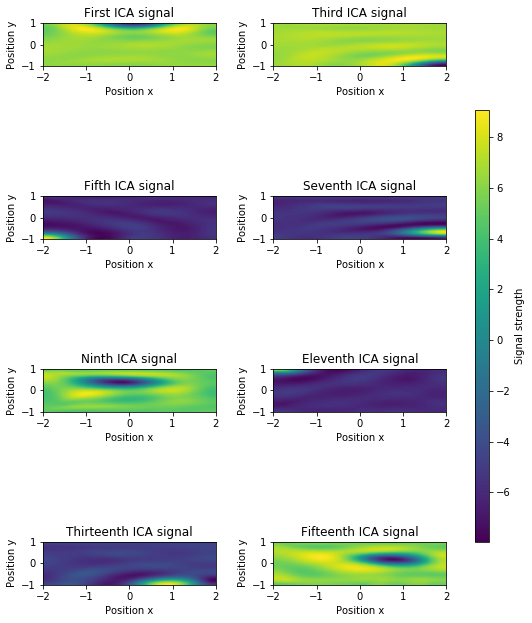

48


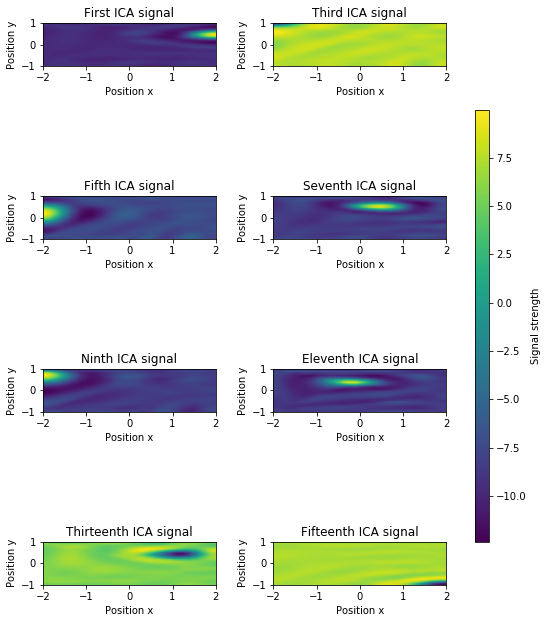

68


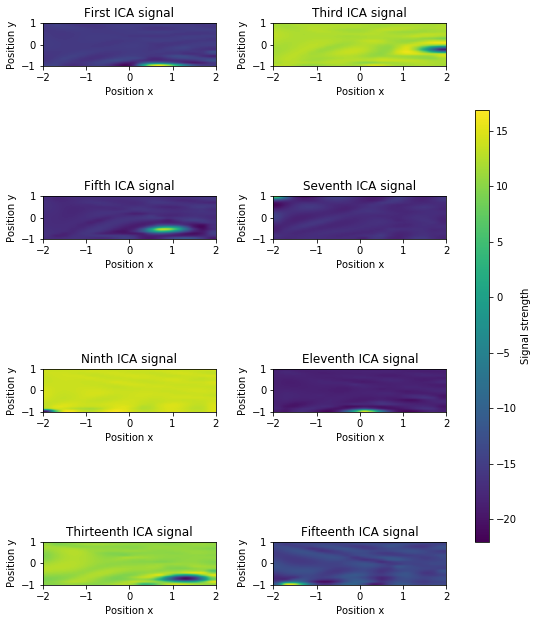

88


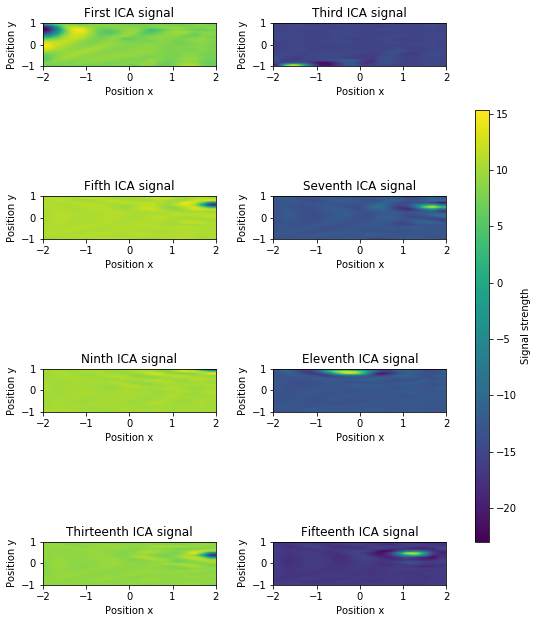

108


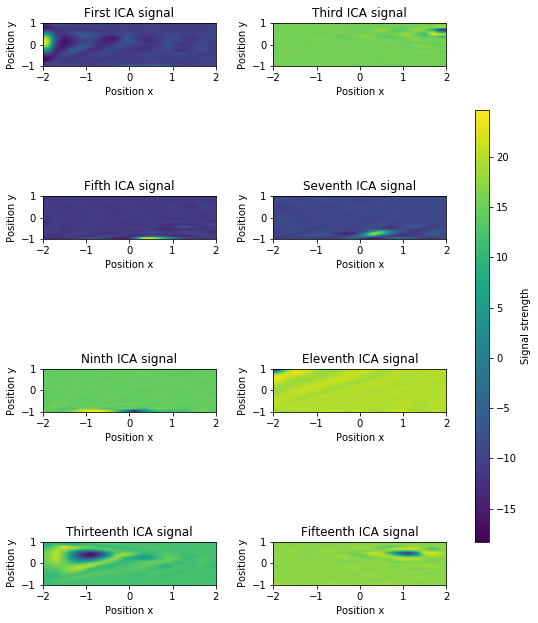

In [126]:
# find maximal J
test_bat.extract_slow_features(expansion=5, whitening=True,J=50)
max_J=test_bat.flow.pop().output_dim

# vary J 
for J in np.arange(8,109,20):
    print(J)
    test_bat.extract_slow_features(expansion=5, ICA=True,J=J)
    sig, sfa =test_bat.sfs_per_area()
    
    if J == 8:
        steps= 1
        counts = ['First','Second','Third','Fourth','Fifth','Sixth','Seventh','Eighth']
    else: 
        steps=2
        counts = ['First','Third','Fifth','Seventh','Ninth','Eleventh','Thirteenth','Fifteenth']
    fig = plot_sfa(sfa,titles=['{0:s} ICA signal'.format(s) for s in counts],rows=4,cols=2,steps=steps)
    fig.savefig('8random_sens_exp5_J{0:d}.png'.format(J))
    plt.show()
    

#### Bonus: sensors rotate with head

In [131]:
test_bat.random_flight(time,head_fixed=False,verbose=True)
test_bat.extract_slow_features(expansion=6,whitening=True)
sig, sfa =test_bat.sfs_per_area()

99.00

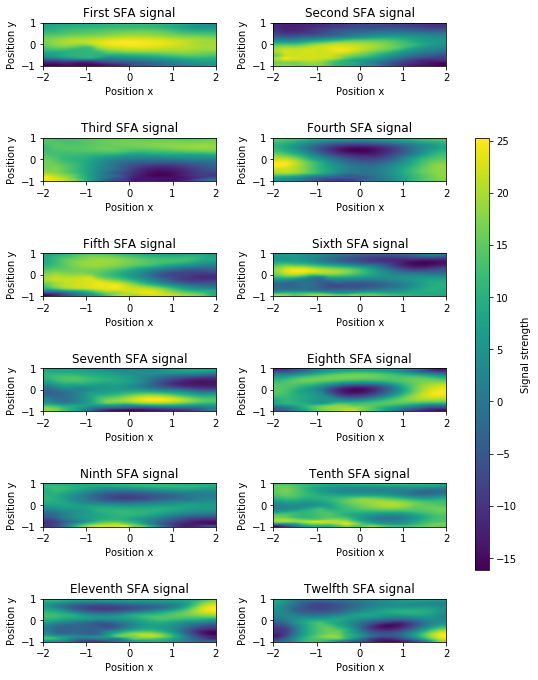

In [137]:
counts = ['First','Second','Third','Fourth','Fifth','Sixth','Seventh','Eighth','Ninth','Tenth', 'Eleventh','Twelfth']
fig = plot_sfa(sfa,titles=['{0:s} SFA signal'.format(s) for s in counts],rows=6,cols=2,steps=1)
fig.savefig('not_head_fixed.png')